<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font face='verdana' size='5' color='black'><b>Use XGBoost to classify tumors with IBM Watson Machine Learning</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
   <tr style='border: none'>
       <th style='border: none'><img src='https://raw.githubusercontent.com/pmservice/wml-sample-notebooks/master/images/cancer_banner-06.png' alt='Icon' width='900'> </th>
   </tr>
</table>

This notebook demonstates how to obtain data from the IBM Watson Studio Gallery, create a predictive model, and score the model.

You will use a publicly available data set, the Breast Cancer Wisconsin (Diagnostic) Data Set, to train an XGBoost Model to classify breast cancer tumors (as benign or malign). There are 569 data points in the Breast Cancer Wisconsin (Diagnostic) Data Set, and each data point has a set of predictors such as radius, texture, perimeter, and area. XGBoost stands for “E<b>x</b>treme <b>G</b>radient <b>Boost</b>ing”.

The XGBoost classifier makes its predictions based on the majority vote from a collection of models which are a set of classification trees. It combines weak learners to create a single strong learner. It is a sequential training process where new learners focus on the misclassified examples of previous learners.


This notebook uses `scikit-learn 0.20`, `xgboost 0.82`, and `watson-machine-learning-client-V4`.


Some familiarity with Python is helpful. This notebook is compatible with Watson Studio Desktop 1.1, Watson Machine Learning Server 1.1, and Python 3.6.


## Learning goals

You will learn how to:

-  Load data into a Pandas DataFrame
-  Explore data
-  Prepare data for training and evaluation
-  Create an XGBoost machine learning model
-  Train and evaluate the model
-  Use cross-validation to optimize model's hyperparameters
-  Save the model
-  Deploy the model for online scoring
-  Score test data


## Table of Contents

This notebook contains the following parts:

1.	[Load and explore the data](#load)
2.	[Create an XGBoost model](#model)  
    2.1 [Split data](#prepare)  
    2.2 [Create an XGBoost model](#create)  
3.  [Setting up](#setup)  
    3.1 [Connecting to Watson Studio Desktop](#wsd)  
    3.2 [Connecting to Watson Machine Learning Server](#wmls)  
4.	[Save the model](#save)  
5.	[Deploy and score the model (WML Server only)](#deploy)  
    5.1 [Create a model deployment](#create_deploy)  
    5.2 [Perform prediction](#pred)  
    5.3 [Delete the deployment and model](#delete)
6.	[Summary and next steps](#summary)

To get started on Watson Machine Learning (WML) Server, find documentation on installion and set up <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-install-over.html" target="_blank" rel="noopener no referrer">here</a>.

-  Local Python environment configurations:
  + Python 3.6
  + XGBoost
  + watson-machine-learning-client-V4
  + matplotlib
  + Seaborn

<a id='load'></a>
## 1. Load and explore the data

In this section, you will load the data into a pandas dataframe and perform an exploratory data analysis (EDA).

The `breast cancer wisconsin data set` is included in `scikit-learn`, hence, only importing the `dataset` module is required.

To load the data into a pandas dataframe, use `pandas` to read the data.

**Example**: First, you need to install the required packages. You can do this by running the following code. Run it only once.<BR><BR>

<div class="alert alert-block alert-warning">
To avoid re-installation when re-running the notebook, try running your notebooks in custom environments. To find out more about setting up custom environments, see <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.0.0/wsj/analyze-data/customize-envs.html">here</a>.<br>
</div>

Import the `load_breast_cancer` module in order to load the `breast cancer wisconsin data set`.

In [1]:
from sklearn.datasets import load_breast_cancer

wisconsin_data = load_breast_cancer()

Load the `breast cancer wisconsin data set` into a `pandas` DataFrame and add the target column - `diagnosis`. Check the first `5` data points (rows) of the data set.

In [2]:
from pandas import DataFrame

df = DataFrame(wisconsin_data.data, columns= wisconsin_data.feature_names)
df['diagnosis'] = wisconsin_data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Run the code in the next cell to view the predictor names and data types.

You can see that the data set has 569 data points and 31 predictors.

In [3]:
# Information about the data set, predictor names, and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

In [4]:
# Information about values in the numerical columns.
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


You can see the distribution of the target values/labels by running the following code.

In [5]:
# Distribution of target values/labels.
df['diagnosis'].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

In [6]:
# Check for NANs.
df.isnull().sum().sum()

0

The data set has no missing values.

In order to make accurate predictions, you need to select the significant predictors by choosing the features that affect the output most. In this case, it is *diagnosis*.

In [7]:
# pairwise correlation of numerical columns
df.corr()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,-0.730029
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,-0.415185
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,-0.742636
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,-0.708984
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,-0.358560
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,-0.596534
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,-0.696360
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,-0.330499
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,0.012838


In [8]:
from matplotlib.pyplot import subplots
from seaborn import boxplot, heatmap

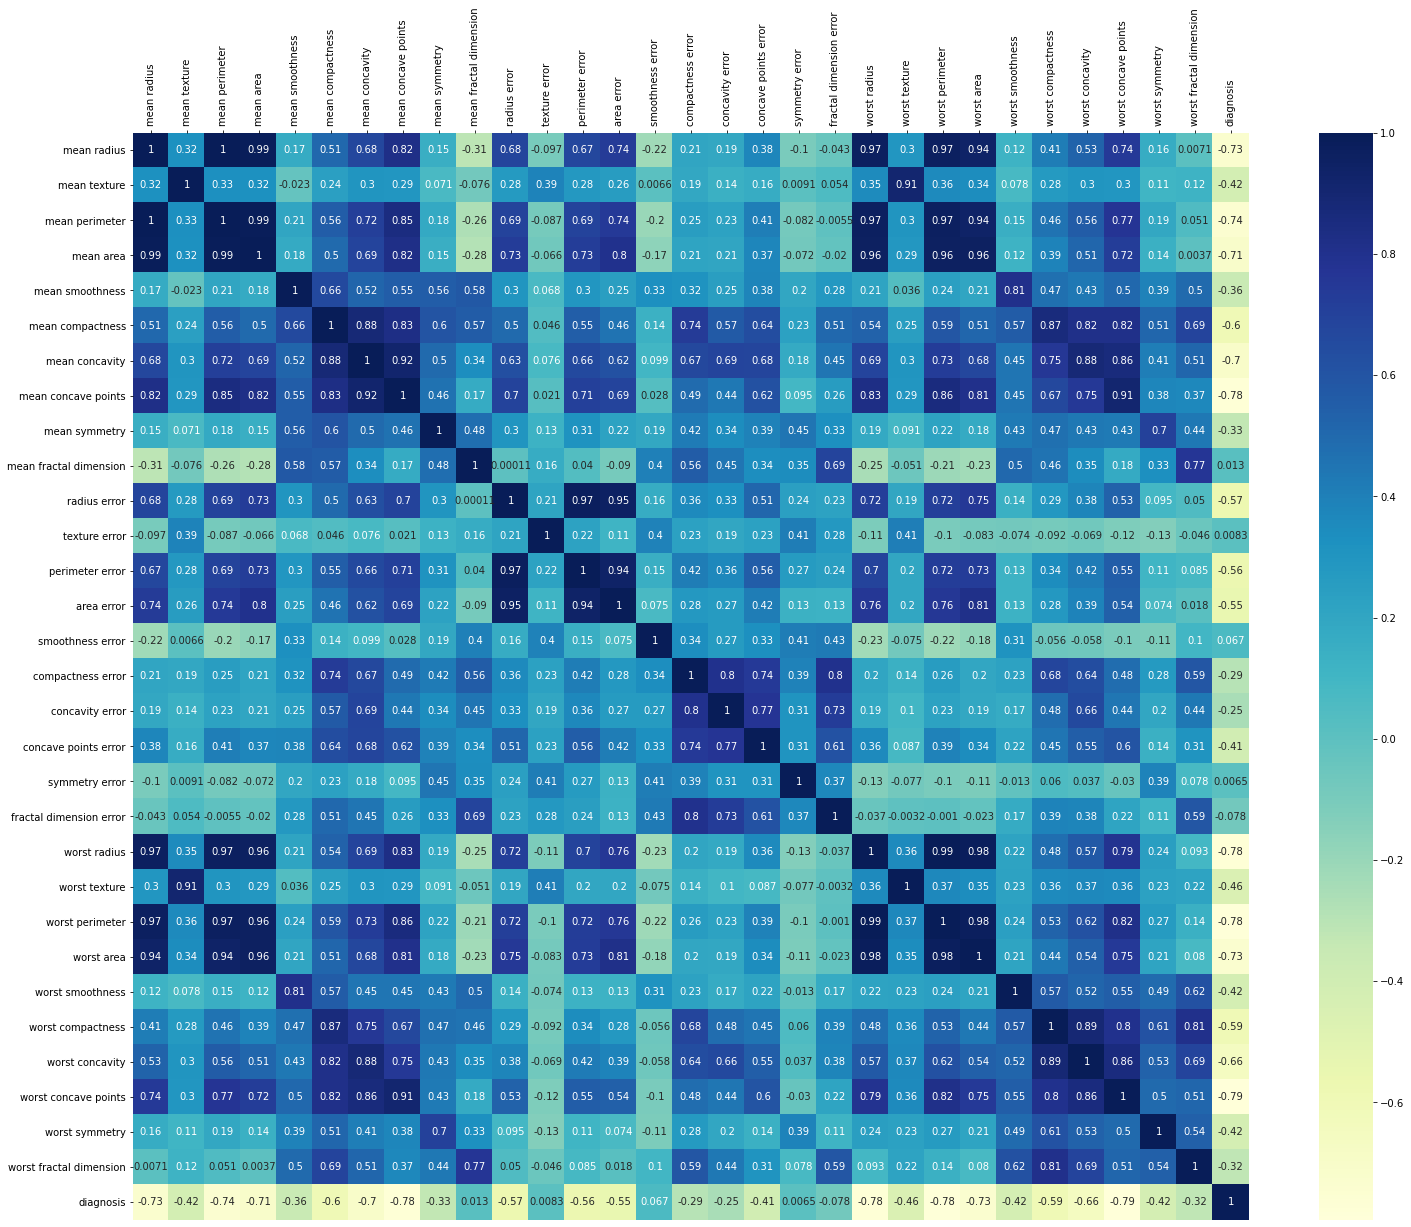

In [9]:
# Plot a correlation heatmap.
subplots(figsize=(25, 20))
hm1 = heatmap(df.corr(), annot=True, cmap='YlGnBu')
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90)
hm1.xaxis.set_ticks_position('top')

This correlation heatmap helps with feature selection because the gradient shows the correlation between the columns of the dataframe. In order to select only the *significant* predictors, you must eliminate features that are highly correlated with each other **(ex: 0.95)**.

With respect to predicting the labels, the most significant predictors can be found by plotting boxplots of the numerical values against the labels. The features with boxplots that show the most variance should be chosen as the predictors for your model.

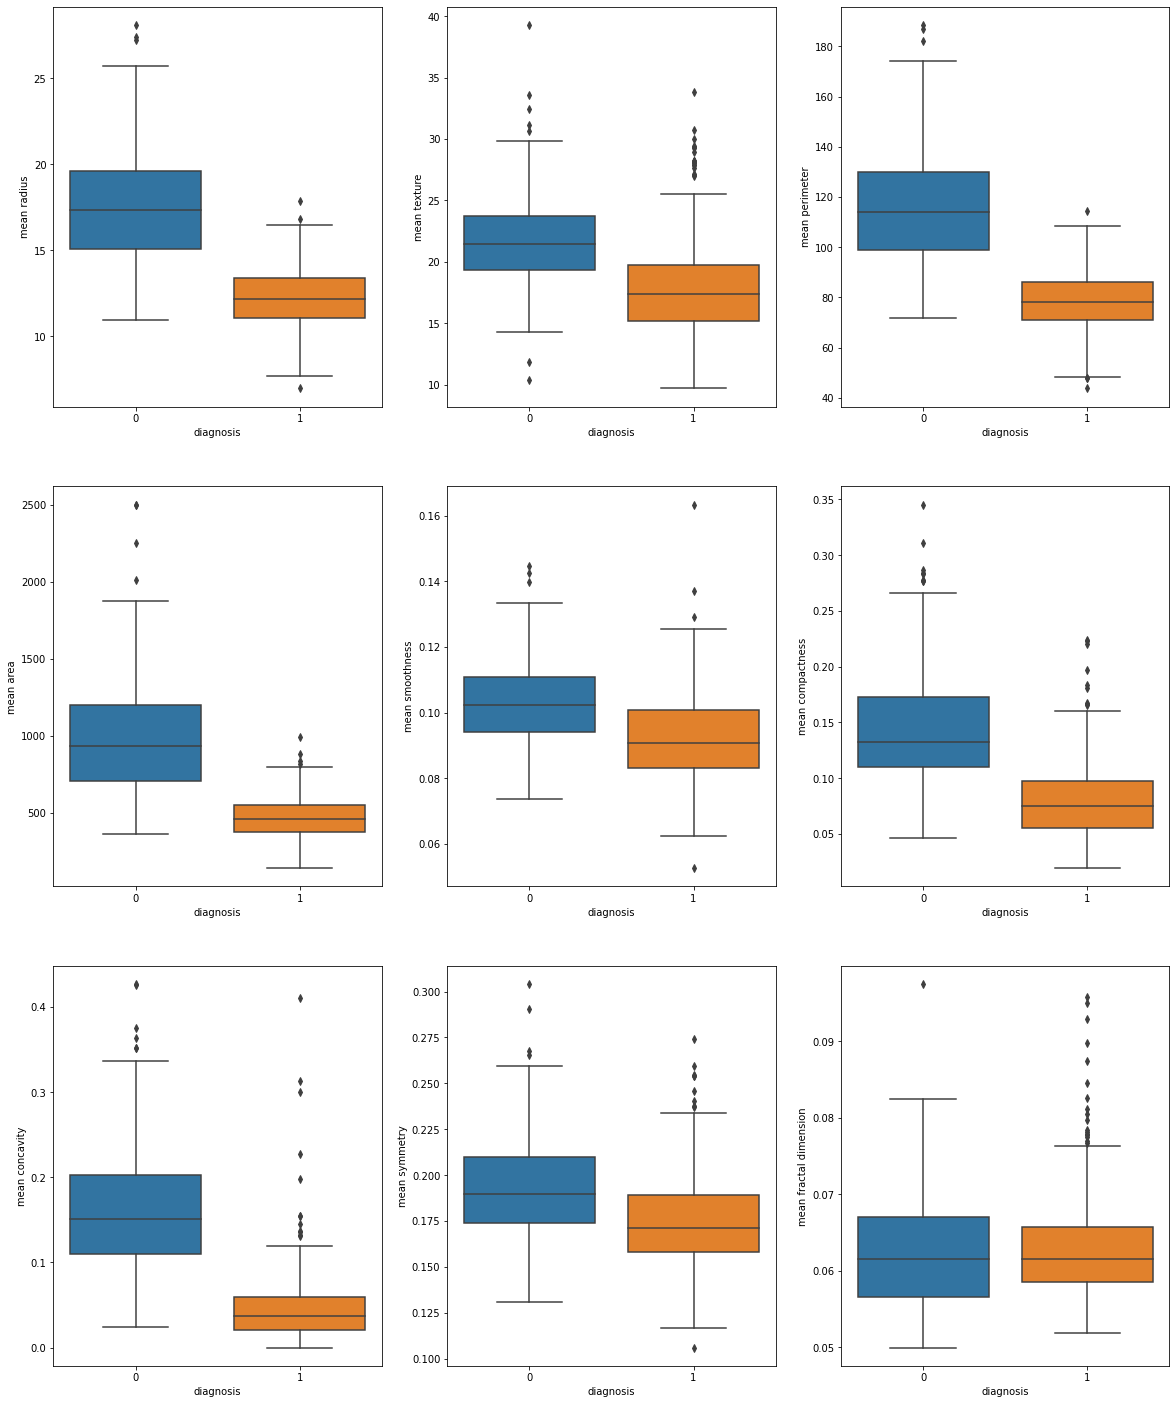

In [10]:
# Plot boxplots of numerical columns.
cont_list = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity', 'mean symmetry',
    'mean fractal dimension'
]
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)
    ) = subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list)):
    boxplot(x='diagnosis', y=cont_list[i], data=df, ax=ax[i])

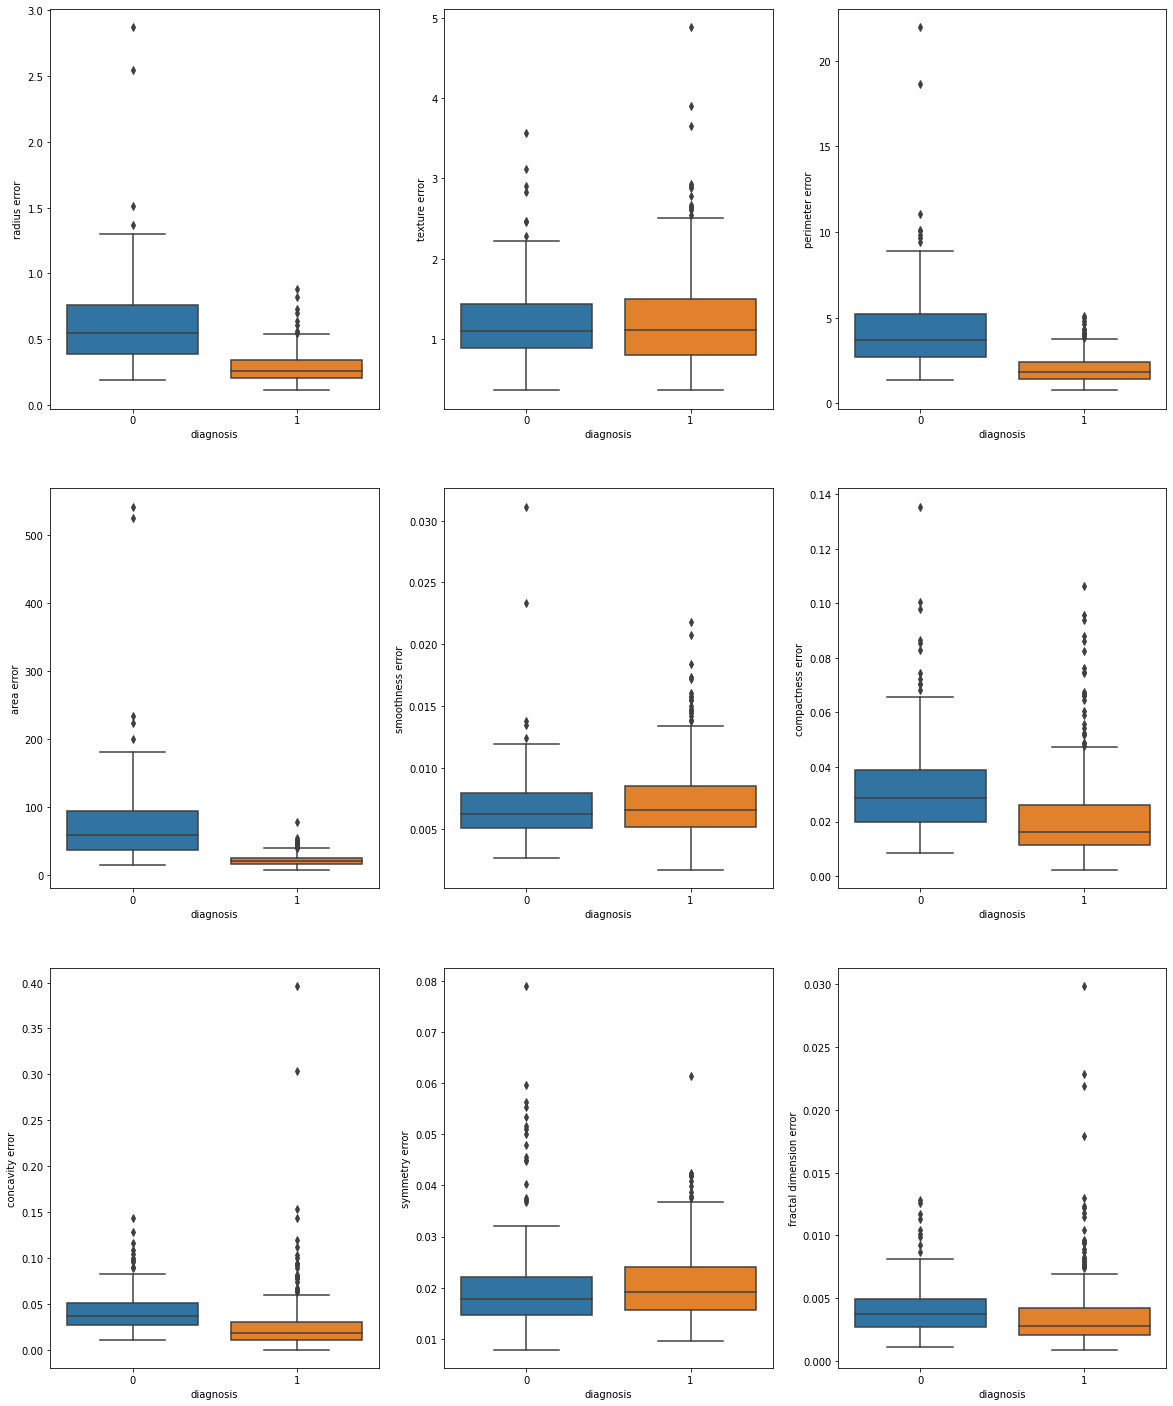

In [11]:
# Plot boxplots of numerical columns.
cont_list2 = [
    'radius error', 'texture error', 'perimeter error',
    'area error', 'smoothness error', 'compactness error',
    'concavity error', 'symmetry error', 'fractal dimension error'
]
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)
    ) = subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list2)):
    boxplot(x='diagnosis', y=cont_list2[i], data=df, ax=ax[i])

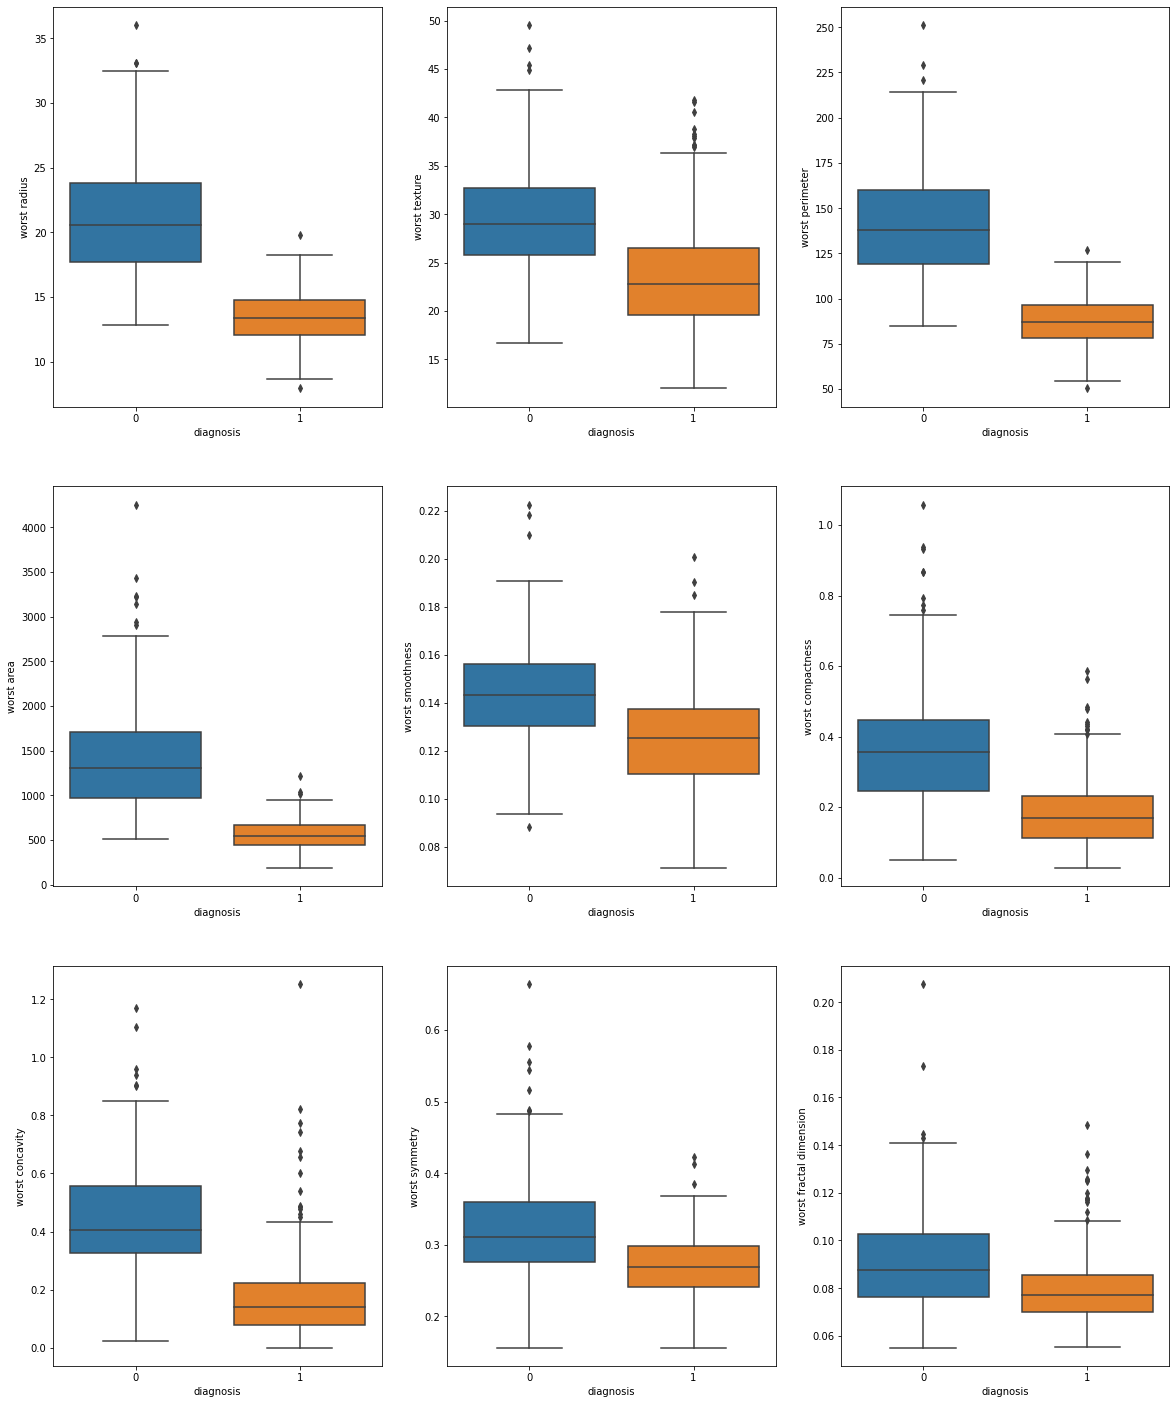

In [12]:
# Plot boxplots of numerical columns.
cont_list3 = [
    'worst radius', 'worst texture', 'worst perimeter',
    'worst area', 'worst smoothness', 'worst compactness',
    'worst concavity', 'worst symmetry', 'worst fractal dimension'
]
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)
    ) = subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list3)):
    boxplot(x='diagnosis', y=cont_list3[i], data=df, ax=ax[i])

Here are boxplots of the most significant features:

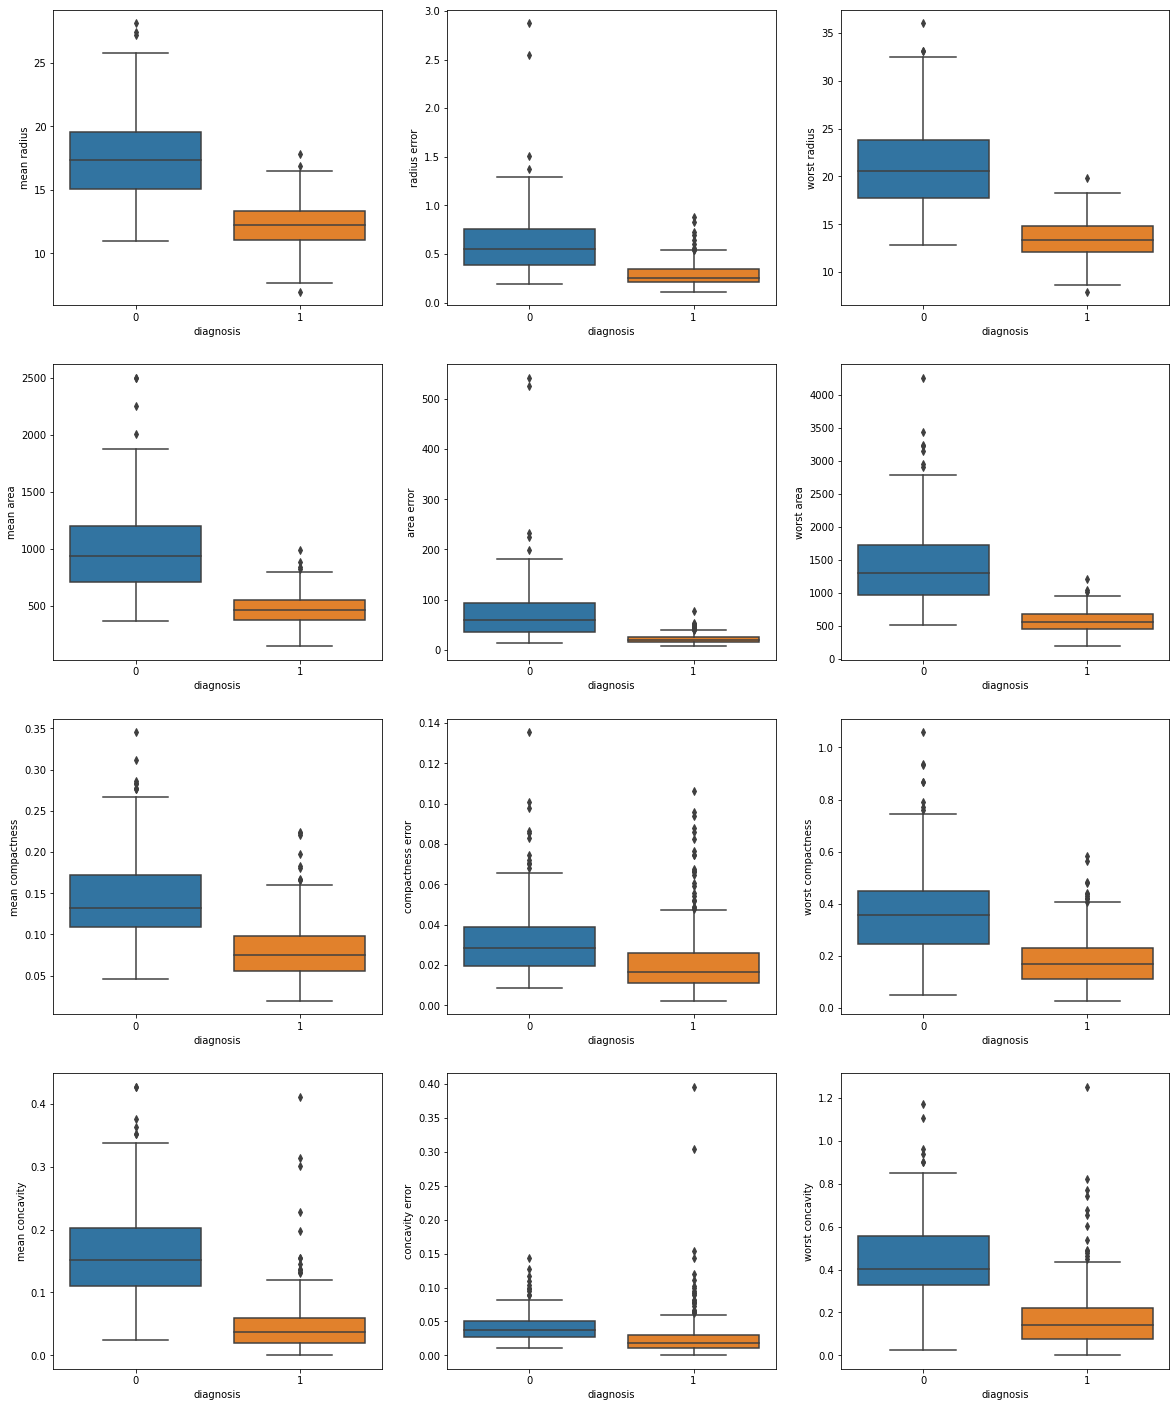

In [13]:
# Compare boxplots of significant numerical columns.
cont_list4 = [
    'mean radius', 'radius error', 'worst radius',
    'mean area', 'area error', 'worst area', 'mean compactness',
    'compactness error', 'worst compactness', 'mean concavity',
    'concavity error', 'worst concavity'
]
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9),
    (ax10, ax11, ax12)) = subplots(4, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for i in range(len(cont_list4)):
    boxplot(x='diagnosis', y=cont_list4[i], data=df, ax=ax[i])

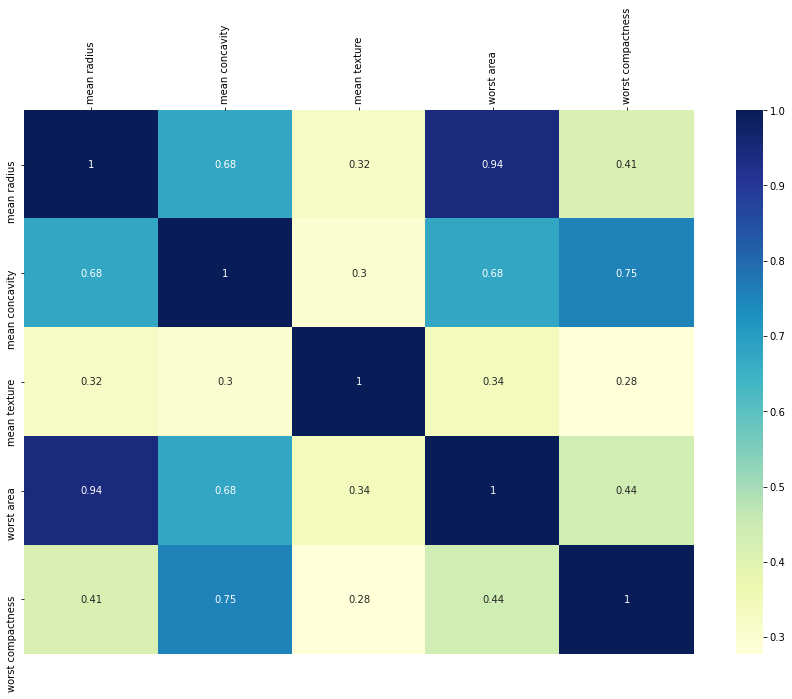

In [14]:
cont_list_f = [
    'mean radius', 'mean concavity', 'mean texture', 'worst area',
    'worst compactness'
]
subplots(figsize=(15, 10))
hm2 = heatmap(df[cont_list_f].corr(), annot=True, cmap='YlGnBu')
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=90)
hm2.xaxis.set_ticks_position('top')

By plotting the boxplots of each numerical column against the diagnosis type, we have picked out the significant features/predictors. More variation in the boxplot implies higher significance. We also eliminate features that are highly correlated. Therefore we can choose *mean radius, mean concavity, mean texture, worst area, worst compactness* as the predictors for our model.

<a id='model'></a>
## 2. Create an XGBoost model

In this section, you will learn how to train and test an XGBoost model.

- [2.1 Split data](#prepare)
- [2.2 Create an XGBoost model](#create)

### 2.1 Split data<a id='prepare'></a>

<div class="alert alert-block alert-warning">
To simply hide the output of pip install instead, use <tt>-q</tt> after <tt>!pip install</tt>.
</div>

In [15]:
!pip install -q scikit-learn==0.20.4

You will pass the data with the selected significant predictors to build the model. You will use the `diagnosis` column as your target variable.

In [16]:
# Choosing the significant predictors.

X = df.iloc[:, [0, 1, 6, 23, 25]]
X = X.values

# Changing the target variables to binary variables
y = df['diagnosis'].astype('category').cat.codes
y = y.values

Split the data set into: 
- Train set
- Test set

In [17]:
# Split the data set and create two data sets.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.35,
                                                    random_state=143)

In [18]:
# List the number of records in each data set.
print('Number of training records: {}'.format(len(X_train)))
print('Number of testing records : {}'.format(len(X_test)))

Number of training records: 369
Number of testing records : 200


The data has been successfully split into two sets:
- The train set, which is the largest group, will be used for training.
- The test set will be used for model evaluation and is used to test the assumptions of the model.

### 2.2 Create an XGBoost model<a id='create'></a>

Install the required packages.<br><br>

<div class="alert-block alert-info"><br>&nbsp;&nbsp;&nbsp;&nbsp;Make sure <tt>xgboost</tt>'s version is 0.82.<br><br>
</div>

In [19]:
!pip install -q xgboost==0.82

Command "python setup.py egg_info" failed with error code 1 in /private/tmp/pip-install-673kk5zd/xgboost/


In [20]:
import xgboost
xgboost.__version__

'0.80'

In [21]:
# Import packages you need to create the XGBoost model.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost.sklearn import XGBClassifier

#### 2.2.1 Create an XGBoost classifier

In this subsection, you will create an XGBoost classifier with default hyperparameters that you will call *xgb_model*. <br><br>

<div class="alert-block alert-info"><br>&nbsp;&nbsp;&nbsp;&nbsp;The following sections will show you how to improve this base model.<br><br>
</div>

In [22]:
# Create the XGB classifier - xgb_model.
xgb_model = XGBClassifier(n_estimators=100)

Display the default parameters for *xgb_model*.

In [23]:
from json import dumps

# List the default parameters.
print(dumps(xgb_model.get_xgb_params(), indent=4))

{
    "base_score": 0.5,
    "booster": "gbtree",
    "colsample_bylevel": 1,
    "colsample_bytree": 1,
    "gamma": 0,
    "learning_rate": 0.1,
    "max_delta_step": 0,
    "max_depth": 3,
    "min_child_weight": 1,
    "missing": null,
    "n_estimators": 100,
    "nthread": 1,
    "objective": "binary:logistic",
    "reg_alpha": 0,
    "reg_lambda": 1,
    "scale_pos_weight": 1,
    "seed": 0,
    "silent": 1,
    "subsample": 1
}


Now, that your XGBoost classifier *xgb_model* is set up, you can train it by using the fit method. You will also evaluate *xgb_model* as the train and test data are being trained.

In [24]:
# Train and evaluate.
xgb_model.fit(X_train,
              y_train,
              eval_metric=['error'],
              eval_set=[((X_train, y_train)), (X_test, y_test)])

[0]	validation_0-error:0.0271	validation_1-error:0.07
[1]	validation_0-error:0.0271	validation_1-error:0.07
[2]	validation_0-error:0.0271	validation_1-error:0.07
[3]	validation_0-error:0.0271	validation_1-error:0.07
[4]	validation_0-error:0.0271	validation_1-error:0.07
[5]	validation_0-error:0.0271	validation_1-error:0.07
[6]	validation_0-error:0.0271	validation_1-error:0.07
[7]	validation_0-error:0.0271	validation_1-error:0.07
[8]	validation_0-error:0.0271	validation_1-error:0.07
[9]	validation_0-error:0.0271	validation_1-error:0.07
[10]	validation_0-error:0.0271	validation_1-error:0.07
[11]	validation_0-error:0.0271	validation_1-error:0.07
[12]	validation_0-error:0.0271	validation_1-error:0.06
[13]	validation_0-error:0.0271	validation_1-error:0.065
[14]	validation_0-error:0.0271	validation_1-error:0.055
[15]	validation_0-error:0.01897	validation_1-error:0.05
[16]	validation_0-error:0.01897	validation_1-error:0.05
[17]	validation_0-error:0.01897	validation_1-error:0.05
[18]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Plot the model performance that was evaluated during the training process to assess the model overfitting factor.

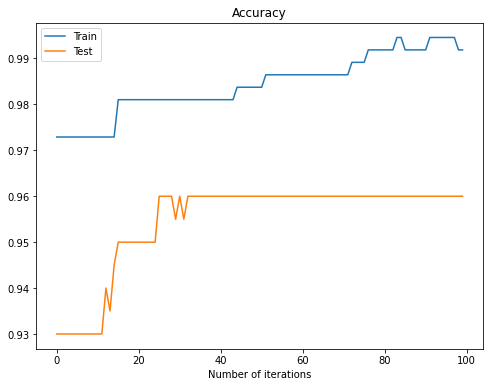

In [25]:
# Plot and display the performance evaluation
xgb_eval = xgb_model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1 - x for x in xgb_eval['validation_0']['error']],
        label='Train')
ax.plot(eval_steps, [1 - x for x in xgb_eval['validation_1']['error']],
        label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations');

You can see that there is model overfitting, and there is no increase in model accuracy after about 40 iterations.

Select the trained model obtained after 40 iterations.

In [26]:
# Select trained model.
n_trees = 40
y_pred = xgb_model.predict(X_test, ntree_limit= n_trees)

In [27]:
# Check the accuracy of the trained model.
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy * 100.))

Accuracy: 96.00%


<div class="alert-block alert-info"><br>&nbsp;&nbsp;&nbsp;&nbsp;You will use the test data accuracy to compare the accuracy of the model with <i>default</i> parameters to the accuracy of the model with <i>tuned</i> parameters.<br><br>
</div>

,0,1
0,66,8
1,0,126


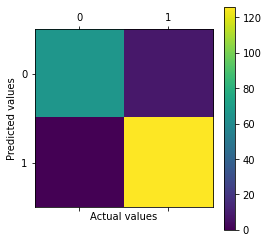

In [28]:
from matplotlib.pyplot import colorbar, matshow, xlabel, ylabel
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
matshow(cm)
colorbar()
xlabel('Actual values')
ylabel('Predicted values')
DataFrame(cm)

This confusion matrix maps the predicted values against the actual values. Here, you can see that 126 benign tumors and 66 malignant tumors have been predicted correctly. However, 8 benign tumors have been incorrectly predicted as malignant. 

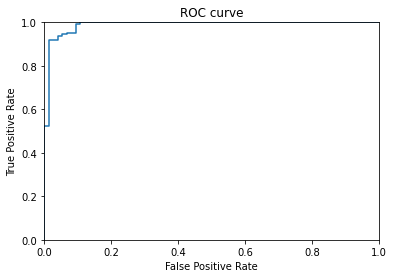

In [29]:
# ROC-AUC curve
from matplotlib.pyplot import plot, title, xlim, ylim
from sklearn.metrics import roc_curve

y_pred_prob = xgb_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plot(fpr, tpr)
xlim([0., 1.])
ylim([0., 1.])
title('ROC curve')
xlabel('False Positive Rate')
ylabel('True Positive Rate');

This is the ROC-AUC curve - the area under the curve represents the accuracy of the predictions. You can see that the area under the curve is large, indicating that the predictions are highly accurate.

#### 2.2.2 Use grid search and cross-validation to tune the model 

You can use grid search and cross-validation to tune your model to achieve better accuracy.

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape an algorithm’s desired behavior. Here you will optimize the model tuning which adds an L1 penalty (`reg_alpha`).

Use a 5-fold cross-validation because your training data set is small.

In the cell below, create the XGBoost pipeline and set up the parameter grid for the grid search.

In [30]:
# Create XGBoost pipeline, set up parameter grid.
xgb_model_gs = XGBClassifier()
parameters = {
    'reg_alpha': [0., 1., 2.],
    'reg_lambda': [0., 1., 2.],
    'n_estimators': [n_trees],
    'seed': [1337]
}

Use ``GridSearchCV`` to search for the best parameters from the specified values in the previous cell.

In [31]:
# Search for the best parameters.
clf = GridSearchCV(estimator=xgb_model_gs,
                   param_grid=parameters,
                   scoring='accuracy',
                   cv=5,
                   verbose=1,
                   n_jobs=1,
                   refit=True)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.5s finished
/Users/jihyoungkim@us.ibm.com/WatsonStudioDesktop/miniconda3/envs/desktop/lib/python3.6/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'reg_alpha': [0.0, 1.0, 2.0], 'reg_lambda': [0.0, 1.0, 2.0], 'n_estimators': [40], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

From the grid scores, you can see performance results of all parameter combinations including the best parameter combination based on model performance.

In [32]:
# View the performance result.
for key in [
        'mean_train_score', 'std_train_score', 'mean_test_score',
        'std_test_score', 'params', 'rank_test_score'
]:
    score = clf.cv_results_[key] if type(
        clf.cv_results_[key]) is list else clf.cv_results_[key].tolist()
    print('{}: {}'.format(key, dumps(score, indent=4)))

mean_train_score: [
    0.9878034035419023,
    0.9844112514451497,
    0.9823796435660842,
    0.9830576096677792,
    0.9823796435660842,
    0.9817039678904086,
    0.9796723600113431,
    0.976287110354907,
    0.976287110354907
]
std_train_score: [
    0.0046048403412189826,
    0.005532389196019985,
    0.0033558792899450623,
    0.004313579171746993,
    0.0033558792899450623,
    0.003479032155672871,
    0.0021699955576428872,
    0.0030274372595458007,
    0.0030274372595458007
]
mean_test_score: [
    0.9539295392953929,
    0.9539295392953929,
    0.9566395663956639,
    0.959349593495935,
    0.959349593495935,
    0.9566395663956639,
    0.9539295392953929,
    0.9539295392953929,
    0.9539295392953929
]
std_test_score: [
    0.021632725516283636,
    0.02887374275378147,
    0.027401640749373662,
    0.023993326216086346,
    0.023993326216086346,
    0.027401640749373662,
    0.03579063516409103,
    0.03579063516409103,
    0.03579063516409103
]
params: [
    {
      

/Users/jihyoungkim@us.ibm.com/WatsonStudioDesktop/miniconda3/envs/desktop/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/jihyoungkim@us.ibm.com/WatsonStudioDesktop/miniconda3/envs/desktop/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Display the accuracy estimated using cross-validation and the hyperparameter values for the best model.

In [33]:
print('Best score: {:.2f}%'.format(clf.best_score_ * 100))
print('Best parameter set: {}'.format(clf.best_params_))

Best score: 95.93%
Best parameter set: {'n_estimators': 40, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'seed': 1337}


Display the accuracy of the best parameter combination on the test set.

In [34]:
y_pred = clf.best_estimator_.predict(X_test, ntree_limit=n_trees)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100.0))

Accuracy: 95.50%


The test set's accuracy is about the same for both the tuned model and the trained model with default hyperparameter values, even though the tuned hyperparameters are different from the default parameters.

## 3. Setting up <a id="setup"></a>

In this section, you will learn how to use the python client to connect to both Watson Studio Desktop (WSD) and Watson Machine Learning (WML) Server. If you only intend to save the model on WSD, you will need to follow the steps in section [3.1 Connecting to Watson Studio Desktop](#wsd).

If you want to use the WML Server, you will need to refer to section [3.2 Connecting to Watson Machine Learning Server](#wmls). From there, you will be able to save, deploy, and score the model in your deployment space on the server.

<div class="alert-block alert-info"><br>&nbsp;&nbsp;&nbsp;&nbsp;The <tt>watson-machine-learning-client</tt> documentation can be found <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">here</a>.<br><br>
</div>

First, import the `watson-machine-learning-client` module and authenticate the service instance.

In [35]:
!pip install -q --upgrade watson-machine-learning-client-V4

In [36]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

### 3.1 Connecting to Watson Studio Desktop <a id="wsd"></a>

To associate the python client with Watson Studio Desktop, use the following credentials.

In [37]:
from project_lib.utils import environment

url = environment.get_common_api_url()
wml_credentials = {
    'instance_id': 'wsd_local',
    'url': url,
    'version': '1.1'
}

Now, instantiate a `WatsonMachineLearningAPIClient` object.

In [38]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [39]:
client.version

'1.0.112'

Setting the default project is mandatory when you use WSD. You can use the cell below.

In [40]:
from project_lib import Project

project = Project.access()
project_id = project.get_metadata()['metadata']['guid']
client.set.default_project(project_id)

'SUCCESS'

To proceed, you can go directly to the Section [4. Save the model](#save).

<a id="wmls"></a>
### 3.2 Connecting to Watson Machine Learning Server <a id="wmls"></a>

In this subsection, you will learn how to set up the Watson Machine learning (WML) Server that is required in order to save, deploy, and score the model.

**Connect to the Watson Machine Learning Server using the Python client**<br><br>

<div class="alert-block alert-info">
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;To install the Watson Machine Learning Server, follow <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-install-over.html" target="_blank" rel="noopener no referrer">these documentation steps</a>.<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;To connect to the WML server and find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-connect.html" target="_blank" rel="noopener no referrer">Documentation</a>.
    <br><br>
</div>

**Action**: Enter your WML Server credentials in the following cell.

In [41]:
# Enter your credentials here.
wml_credentials = {
    'url': '<URL>:31843',
    'username': '---',
    'password': '---',
    'instance_id': 'wml_local',
    'version': '2.0'
}

In [42]:
# @hidden_cell

wml_credentials = {
    'url': 'https://wmlserver-dev-test.ml.test.cloud.ibm.com:31843',
    'username': 'admin',
    'password': 'password',
    'instance_id': 'wml_local',
    'version': '2.0'
}

Instantiate the `WatsonMachineLearningAPIClient` object.

In [43]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [44]:
client.version

'1.0.112'

Since you are using WML Server in this section, you can obtain the space UID by using the following cells.

<div class="alert-block alert-info"><br>
&nbsp;&nbsp;&nbsp;&nbsp;You can create your own <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/analyze-data/ml-spaces_local.html" target="_blank" rel="noopener no referrer">deployment space</a> by selecting <b>Deployment Spaces</b> from the Navigation Menu on the top left of this page.<br><br></div>

Alternatively, you can create a deployment and obtain its UID using the code in the following cell.

In [45]:
# Obtain the UId of your space
def guid_from_space_name(client, space_name):
    instance_details = client.service_instance.get_details()
    space = client.spaces.get_details()
    return (next(item for item in space['resources']
                 if item['entity']['name'] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR_DEPLOYMENT_SPACE')`.

In [46]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR_DEPLOYMENT_SPACE')
print('Space UID = {}'.format(space_uid))

Space UID = 3ce5e796-f127-431a-9609-46456e10d274


Setting the default space is mandatory when you use WML Server. You can set this using the cell below.

In [47]:
client.set.default_space(space_uid)

'SUCCESS'

Now, you can save and deploy the model to the deployment space.

<a id='save'></a>
## 4. Save the model

First, you need to create the model metadata. Since the model was made using a scikit-learn wrapper for xgboost, the `TYPE` is set as `scikit-learn_0.20` and the `RUNTIME_UID` is set as `xgboost_0.82-py3.6`.

In [48]:
# Model Metadata.
software_spec_uid = client.software_specifications.get_uid_by_name(
    'xgboost_0.82-py3.6')

meta_props={
    client.repository.ModelMetaNames.NAME: 'XGBoost model for breast cancer',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    client.repository.ModelMetaNames.TYPE: 'xgboost_0.82',
}

You can extract the model UID from the saved model details.

In [49]:
# Create the model artifact.
model_artifact = client.repository.store_model(clf.best_estimator_, meta_props)
model_uid = client.repository.get_model_uid(model_artifact)
print('Model UID = {}'.format(model_uid))

Model UID = 1ccb2e45-601b-437b-8e5a-62302e4edc79


Obtain the saved model metadata from WML using the model UID.

In [50]:
# Details about the model.
model_details = client.repository.get_details(model_uid)
print(dumps(model_details, indent=4))

{
    "metadata": {
        "name": "XGBoost model for breast cancer",
        "guid": "1ccb2e45-601b-437b-8e5a-62302e4edc79",
        "id": "1ccb2e45-601b-437b-8e5a-62302e4edc79",
        "modified_at": "2020-08-28T16:55:10.002Z",
        "created_at": "2020-08-28T16:55:09.002Z",
        "owner": "1000330999",
        "href": "/v4/models/1ccb2e45-601b-437b-8e5a-62302e4edc79?space_id=3ce5e796-f127-431a-9609-46456e10d274",
        "space_id": "3ce5e796-f127-431a-9609-46456e10d274"
    },
    "entity": {
        "name": "XGBoost model for breast cancer",
        "content_status": {
            "state": "persisted"
        },
        "software_spec": {
            "id": "39e31acd-5f30-41dc-ae44-60233c80306e"
        },
        "space": {
            "id": "3ce5e796-f127-431a-9609-46456e10d274",
            "href": "/v4/spaces/3ce5e796-f127-431a-9609-46456e10d274"
        },
        "type": "xgboost_0.82"
    }
}


You can list all stored models using the `list_models` method.

In [51]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  -------------------------------  ------------------------  ------------
GUID                                  NAME                             CREATED                   TYPE
1ccb2e45-601b-437b-8e5a-62302e4edc79  XGBoost model for breast cancer  2020-08-28T16:55:09.002Z  xgboost_0.82
------------------------------------  -------------------------------  ------------------------  ------------


<div class="alert-block alert-info"><br>
&nbsp;&nbsp;&nbsp;&nbsp;From the list of stored models, you can see that model is successfully saved. <br>

&nbsp;&nbsp;&nbsp;&nbsp;With Watson Studio Desktop credentials, this means you have saved the model in your project.<br>&nbsp;&nbsp;&nbsp;&nbsp;You can see the saved model in your project UI by clicking on your project name in the breadcrumb at the top of the application. <br>

&nbsp;&nbsp;&nbsp;&nbsp;With WML Server credentials, this means that you have saved the model in your deployment space.<br>&nbsp;&nbsp;&nbsp;&nbsp;You can view your model by selecting <b>Deployment Spaces</b> from the Navigation Menu and clicking on your deployment space name.<br>
<br></div>

If you are using WML Server, proceed to section [5. Deploy and score the model (WML Server only)](#deploy). If you are using Watson Studio Desktop, you may skip to the [summary](#summary).

# 5. Deploy and score the model (WML Server only) <a id="deploy"></a>


In this section, you will learn how to create an online scoring endpoint and score a new data record in the WML repository.

### 5.1 Create a model deployment<a id="create_deploy"></a>

Now, you can create a deployment, *Predict breast cancer*.

In [52]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: 'Predict breast cancer',
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [53]:
# Create the deployment.
deployment_details = client.deployments.create(model_uid,
                                               meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '1ccb2e45-601b-437b-8e5a-62302e4edc79' started

#######################################################################################


initializing..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='07445697-d238-46c5-b1fe-8c591868ce51'
------------------------------------------------------------------------------------------------




Obtain the list of all deployments.

In [54]:
# List the deployments.
client.deployments.list()

------------------------------------  ---------------------  -----  ------------------------  -------------
GUID                                  NAME                   STATE  CREATED                   ARTIFACT_TYPE
07445697-d238-46c5-b1fe-8c591868ce51  Predict breast cancer  ready  2020-08-28T16:55:13.268Z  model
------------------------------------  ---------------------  -----  ------------------------  -------------


<div class="alert-block alert-info"><br>
&nbsp;&nbsp;&nbsp;&nbsp;From the list of deployed models in the deployment space, you can see that the <b>Predict breast cancer</b> model has been successfully deployed.<br>
<br></div>

In [55]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment UID = {}'.format(deployment_uid))

Deployment UID = 07445697-d238-46c5-b1fe-8c591868ce51


### 5.2 Perform prediction <a id="pred"></a>

Now, you can score the data and predict whether each instance is a benign or malignant tumor. Prepare scoring payload.

In [56]:
# Prepare scoring payload.
job_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [{
        'values': [list(X_test[0]), list(X_test[1])]
    }]
}
print(dumps(job_payload, indent=4))

{
    "input_data": [
        {
            "values": [
                [
                    12.23,
                    19.56,
                    0.04187,
                    638.4,
                    0.2042
                ],
                [
                    16.27,
                    20.71,
                    0.1478,
                    1121.0,
                    0.2947
                ]
            ]
        }
    ]
}


In [57]:
# Perform prediction and display the result.
job_details = client.deployments.score(deployment_uid, job_payload)
print(dumps(job_details, indent=4))

{
    "predictions": [
        {
            "fields": [
                "prediction",
                "probability"
            ],
            "values": [
                [
                    0.9686809778213501,
                    3.431711435317993
                ],
                [
                    0.018459711223840714,
                    -3.9735324382781982
                ]
            ]
        }
    ]
}


**Result**: The patient records are classified as a benign tumor and a malignant tumor respectively.

### 5.3 Delete the deployment and model<a id='delete'></a>

Use the following method to delete the deployment.

In [58]:
client.deployments.delete(deployment_uid)

'SUCCESS'

In [59]:
client.deployments.list()

----  ----  -----  -------  -------------
GUID  NAME  STATE  CREATED  ARTIFACT_TYPE
----  ----  -----  -------  -------------


You can delete the model as well by running the following cell.

In [60]:
client.repository.delete(model_uid)

'SUCCESS'

In [61]:
client.repository.list_models()

----  ----  -------  ----
GUID  NAME  CREATED  TYPE
----  ----  -------  ----


<a id='summary'></a>
## 6. Summary and next steps     

You have successfully completed this notebook! 

You learned how to use a machine learning algorithm called XGBoost and save the model both on Watson Studio Desktop and Watson Machine Learning Server. You can now deploy, and score the model on WML Server as well.

### Resources <a id="resources"></a>

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success">

<h4>IBM documentation</h4>
<br>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/overview.html" target="_blank" rel="noopener noreferrer">Watson Machine Learning Server</a></li>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
 <li> <a href="https://www.python.org" target="_blank" rel="noopener noreferrer">Official Python website</a></li>
 <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
 <li> <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html" target="_blank" rel="noopener noreferrer">Pandas DataFrame</a></li>
 <li> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" target="_blank" rel="noopener noreferrer">scikit-learn: Grid Search</a></li>
 <li> <a href="https://seaborn.pydata.org" target="_blank" rel="noopener noreferrer">Seaborn</a></li>
</div>

### Citation

Lichman, M. (2013). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

### Authors

**Wojciech Sobala** is a Data Scientist at IBM.  
**Ananya Kaushik** is a Data Scientist at IBM.

Copyright © 2017-2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>